# Projekt finalny - sieci rekurencyjne

Celem tegoż dokumentu jest zbadanie i prównanie różnych architekur sieci reukrencyjnych na przykładzie predykcji temperatury w mieście Jena na podstawie danych historycznych.
DO tego celu wykorzystana zostanie baza odczytów temperatury, ciśnienia powietrza, wilgotności, kierunku wiatru itp. (w sumie 14 parametrów), które rejestrowano w latach 2009-2016 za pomocą czujników zamontowanych na dachu budynku w miasto Jena w Niemczech. Zbiór danych jest dostępna pod adresem: https://s3.amazonaws.com/keras-datasets/jenaclimate2009_2016.csv.zip.

# Przygotowanie danych

In [15]:
import pandas as pd

# reading input data from a file
file_name='jena_climate_2009_2016.csv'
data=pd.read_csv(file_name)
print(data)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90   
1       01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28   
2       01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31   
3       01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07   
4       01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04   
...                     ...       ...       ...       ...          ...   
420446  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420447  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420448  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420449  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420450  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
0        93.30          3.33          3.

In [16]:
for d in data.columns:
    print(d)

Date Time
p (mbar)
T (degC)
Tpot (K)
Tdew (degC)
rh (%)
VPmax (mbar)
VPact (mbar)
VPdef (mbar)
sh (g/kg)
H2OC (mmol/mol)
rho (g/m**3)
wv (m/s)
max. wv (m/s)
wd (deg)


In [17]:
import numpy as np

# data conversion to array and normalization
data=np.array(np.array(data)[:,1:15],dtype=float)
mean=data.mean(axis=0)
data-=mean
std=data.std(axis=0)
data/=std
print('mean:',np.round(mean,2))
print('std :',np.round(std,2))
# preparation of training data
steps=144
shift=1 # point of prediction in the future 1 - 10 minutes ahead, 144 - 24 hrs ahead
train_size=10000
train_x=np.zeros((train_size,steps,14))
train_y=np.zeros((train_size,1))
for i in range(0,train_size):
    for j in range(0,steps):
        train_x[i,j,:]=data[i+j]
        train_y[i]=data[i+steps+shift][1]

mean: [ 989.21    9.45  283.49    4.95   76.01   13.58    9.53    4.04    6.02
    9.64 1216.07    2.13    3.53  174.73]
std : [ 8.36  8.42  8.5   6.73 16.48  7.74  4.18  4.9   2.66  4.24 39.98  1.54
  2.34 86.68]


In [6]:
# preparing the test set
test_size=1000
test_shift=steps*800
test_x=np.zeros((test_size,steps,14))
test_y=np.zeros((test_size,1))
for i in range(0,test_size):
    for j in range(0,steps):
        test_x[i,j,:]=data[i+j+test_shift]
        test_y[i]=data[i+steps+shift+test_shift][1]

In [7]:
import matplotlib.pyplot as plt

def plot_model(model_path):
  model = tf.keras.models.load_model(model_path)
  model.evaluate(test_x,test_y)

  z=model.predict(test_x)
  plt.plot(test_y,'green')
  plt.plot(z,'red')
  plt.show()


# Badanie wpływu użytych jednostek rekurencyjnych na dokładność predykcji

Poniżej zbadano dokłdność predykcji sieci zbudowanych w oparciu o różne komponent - SimpleRNN, LSTM i GRU. Do nauki każdej z nich wykorzystano funkcję optymalizującą Adam oraz do propagowania użyto błędu średnio-kwadratowego. Trening każdej z wariantów sieci odbywał się na przestrzenii 50 epok. Każda z architektur poniżej składałam się z jednej warstwy rekurencyjnej z funkcją aktywacji *tanh* oraz warstwy liniowej.

## SimpleRNN


In [ ]:
import tensorflow as tf

# preparation of a network model
model=tf.keras.models.Sequential(name='SimpleRNN')
model.add(tf.keras.layers.Input(shape=(steps,14)))
model.add(tf.keras.layers.SimpleRNN(2,activation='tanh'))
model.add(tf.keras.layers.Dense(1,activation='linear'))
model.summary()

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2)                 34        
                                                                 
 dense_8 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='Adam',loss='mae')
model.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model,'model_simplernn_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 9s 26ms/step - loss: 0.8858
Epoch 2/50
313/313 [==============================] - 7s 22ms/step - loss: 0.2976
Epoch 3/50
313/313 [==============================] - 9s 29ms/step - loss: 0.1451
Epoch 4/50
313/313 [==============================] - 10s 31ms/step - loss: 0.1117
Epoch 5/50
313/313 [==============================] - 8s 25ms/step - loss: 0.0902
Epoch 6/50
313/313 [==============================] - 8s 27ms/step - loss: 0.0700
Epoch 7/50
313/313 [==============================] - 7s 23ms/step - loss: 0.0539
Epoch 8/50
313/313 [==============================] - 11s 37ms/step - loss: 0.0457
Epoch 9/50
313/313 [==============================] - 8s 26ms/step - loss: 0.0408
Epoch 10/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0379
Epoch 11/50
313/313 [==============================] - 9s 28ms/step - loss: 0.0354
Epoch 12/50
313/313 [==============================] - 7s 23ms/step - loss: 0.0340
Epoch 13/5

<ipython-input-23-d54e57ec9018>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'model_simplernn_recurrent.h5')


32/32 [==============================] - 0s 7ms/step


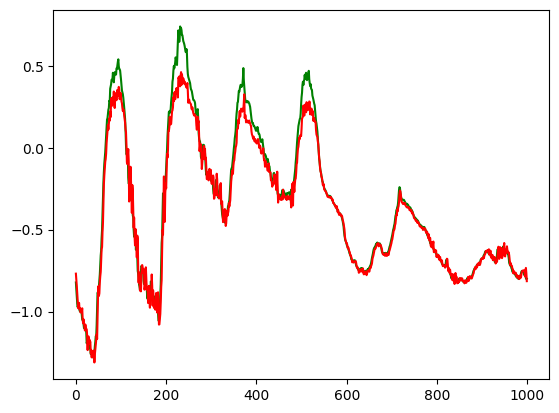

In [ ]:
plot_model('model_simplernn_recurrent.h5')

## LSTM

In [ ]:
import tensorflow as tf

# preparation of a network model
model_lstm=tf.keras.models.Sequential(name='LSTM')
model_lstm.add(tf.keras.layers.Input(shape=(steps,14)))
model_lstm.add(tf.keras.layers.LSTM(2,activation='tanh'))
model_lstm.add(tf.keras.layers.Dense(1,activation='linear'))
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 139 (556.00 Byte)
Trainable params: 139 (556.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer='Adam',loss='mae')
model_lstm.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_lstm,'model_lstm_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 16s 44ms/step - loss: 0.8449
Epoch 2/50
313/313 [==============================] - 14s 44ms/step - loss: 0.3038
Epoch 3/50
313/313 [==============================] - 14s 44ms/step - loss: 0.2053
Epoch 4/50
313/313 [==============================] - 14s 44ms/step - loss: 0.1224
Epoch 5/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0918
Epoch 6/50
313/313 [==============================] - 16s 50ms/step - loss: 0.0750
Epoch 7/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0642
Epoch 8/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0574
Epoch 9/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0528
Epoch 10/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0492
Epoch 11/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0466
Epoch 12/50
313/313 [==============================] - 14s 44ms/step - loss: 0.0440
E

<ipython-input-25-6bc8def6f709>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_lstm,'model_lstm_recurrent.h5')


32/32 [==============================] - 1s 16ms/step


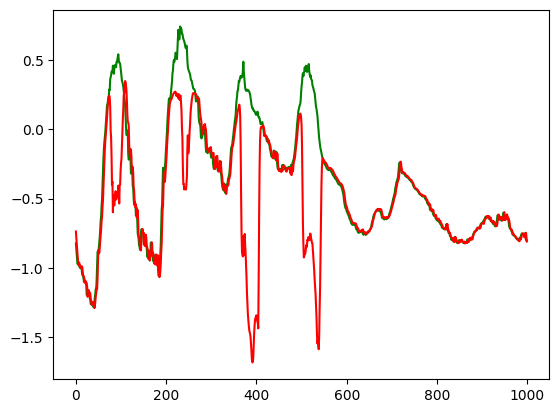

In [ ]:
plot_model('model_lstm_recurrent.h5')

## GRU


In [ ]:
import tensorflow as tf

# preparation of a network model
model_gru=tf.keras.models.Sequential(name='GRU')
model_gru.add(tf.keras.layers.Input(shape=(steps,14)))
model_gru.add(tf.keras.layers.GRU(2,activation='tanh'))
model_gru.add(tf.keras.layers.Dense(1,activation='linear'))
model_gru.summary()


Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 2)                 108       
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_gru.compile(optimizer='Adam',loss='mae')
model_gru.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_gru,'model_gru_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 18s 50ms/step - loss: 0.3539
Epoch 2/50
313/313 [==============================] - 17s 55ms/step - loss: 0.1846
Epoch 3/50
313/313 [==============================] - 15s 49ms/step - loss: 0.1076
Epoch 4/50
313/313 [==============================] - 15s 49ms/step - loss: 0.0770
Epoch 5/50
313/313 [==============================] - 17s 53ms/step - loss: 0.0583
Epoch 6/50
313/313 [==============================] - 16s 51ms/step - loss: 0.0473
Epoch 7/50
313/313 [==============================] - 15s 49ms/step - loss: 0.0401
Epoch 8/50
313/313 [==============================] - 15s 49ms/step - loss: 0.0364
Epoch 9/50
313/313 [==============================] - 15s 50ms/step - loss: 0.0338
Epoch 10/50
313/313 [==============================] - 16s 50ms/step - loss: 0.0318
Epoch 11/50
313/313 [==============================] - 16s 50ms/step - loss: 0.0308
Epoch 12/50
313/313 [==============================] - 16s 52ms/step - loss: 0.0296
E

<ipython-input-34-1b03ca00178c>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_gru,'model_gru_recurrent.h5')


32/32 [==============================] - 1s 12ms/step


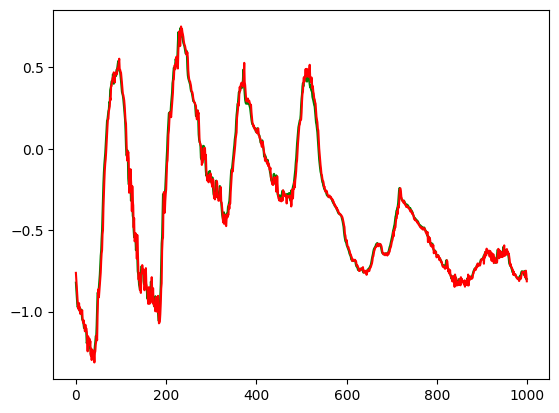

In [ ]:
plot_model('model_gru_recurrent.h5')



Wnioski:

> Jak wiać z powyższych wyników, najmniejszą wartość na końcu nauki uzyskała bramka GRU, następnie SimpleRNN i LSTM. Natomiast jednak w przypadku danych testowych najmniejszą stratę uzyskał LSTM, jednakże wizulanie najlepiej przewidziała wartości jednostka GRU.

> W przypadku LSTM widać, że dla pików wartości model sobie nie poradził. W przypadku SimpleRNN wartości te są nieco bliższe wzorcowi, jednakże nadal błąd jest nieco spory. Z kolei GRU wizulnie odwzorował poprawnie dane postawione na wejściu sieci.





---



# Badanie wpływu głębokości architektury modelu na jakość pedykcji

W tej sekcji wybrano jako jednostkę rekruencyjną budującą sieć LSTM, z racji niezadowalających wyników i badano jak różne liczby warst oraz jednostek w warstwie wpływa na uzyskane wyniki.

In [11]:
import tensorflow as tf

# preparation of a network model
model_lstm_64=tf.keras.models.Sequential(name='LSTM')
model_lstm_64.add(tf.keras.layers.Input(shape=(steps,14)))
model_lstm_64.add(tf.keras.layers.LSTM(64,activation='tanh'))
model_lstm_64.add(tf.keras.layers.Dense(1,activation='linear'))
model_lstm_64.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                20224     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20289 (79.25 KB)
Trainable params: 20289 (79.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm_64.compile(optimizer='Adam',loss='mae')
model_lstm_64.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_lstm_64,'model_lstm_64_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 24s 69ms/step - loss: 0.0828
Epoch 2/50
313/313 [==============================] - 24s 76ms/step - loss: 0.0362
Epoch 3/50
313/313 [==============================] - 27s 86ms/step - loss: 0.0334
Epoch 4/50
313/313 [==============================] - 29s 94ms/step - loss: 0.0312
Epoch 5/50
313/313 [==============================] - 22s 71ms/step - loss: 0.0290
Epoch 6/50
313/313 [==============================] - 27s 87ms/step - loss: 0.0281
Epoch 7/50
313/313 [==============================] - 25s 79ms/step - loss: 0.0271
Epoch 8/50
313/313 [==============================] - 20s 64ms/step - loss: 0.0264
Epoch 9/50
313/313 [==============================] - 27s 85ms/step - loss: 0.0269
Epoch 10/50
313/313 [==============================] - 24s 78ms/step - loss: 0.0267
Epoch 11/50
313/313 [==============================] - 20s 64ms/step - loss: 0.0259
Epoch 12/50
313/313 [==============================] - 22s 72ms/step - loss: 0.0256
E

<ipython-input-41-27ab80258d2e>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_lstm_64,'model_lstm_64_recurrent.h5')


32/32 [==============================] - 1s 20ms/step


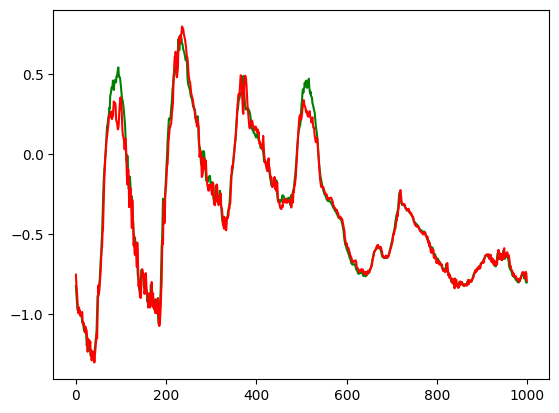

In [ ]:
plot_model('model_lstm_64_recurrent.h5')

Zwiększenie rozmiaru wyjścia z jednostki LSTM w ramach jednej warstwy pozwoliło na dokładniesze przewidzenie wartości. Jednakże, nadal w porównaniu z GRU predykcja wychodzi gorzej lecz w prówaniu z wyjściem 2, udało się zmniejszyć błąd działania modelu aż o 0.1491.



---



In [ ]:
import tensorflow as tf

# preparation of a network model
model_lstm_v2=tf.keras.models.Sequential(name='LSTM')
model_lstm_v2.add(tf.keras.layers.Input(shape=(steps,14)))
model_lstm_v2.add(tf.keras.layers.LSTM(2,activation='tanh',return_sequences=True))
model_lstm_v2.add(tf.keras.layers.LSTM(2,activation='tanh'))
model_lstm_v2.add(tf.keras.layers.Dense(1,activation='linear'))
model_lstm_v2.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 144, 2)            136       
                                                                 
 lstm_5 (LSTM)               (None, 2)                 40        
                                                                 
 dense_9 (Dense)             (None, 1)                 3         
                                                                 
Total params: 179 (716.00 Byte)
Trainable params: 179 (716.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm_v2.compile(optimizer='Adam',loss='mae')
model_lstm_v2.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_lstm_v2,'model_lstm_v2_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 32s 87ms/step - loss: 0.6718
Epoch 2/50
313/313 [==============================] - 28s 90ms/step - loss: 0.3480
Epoch 3/50
313/313 [==============================] - 27s 87ms/step - loss: 0.2961
Epoch 4/50
313/313 [==============================] - 27s 87ms/step - loss: 0.2309
Epoch 5/50
313/313 [==============================] - 27s 87ms/step - loss: 0.1429
Epoch 6/50
313/313 [==============================] - 27s 86ms/step - loss: 0.1117
Epoch 7/50
313/313 [==============================] - 27s 86ms/step - loss: 0.0943
Epoch 8/50
313/313 [==============================] - 28s 89ms/step - loss: 0.0846
Epoch 9/50
313/313 [==============================] - 27s 86ms/step - loss: 0.0764
Epoch 10/50
313/313 [==============================] - 27s 87ms/step - loss: 0.0682
Epoch 11/50
313/313 [==============================] - 27s 86ms/step - loss: 0.0620
Epoch 12/50
313/313 [==============================] - 27s 86ms/step - loss: 0.0561
E

<ipython-input-46-14bb2f493d49>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_lstm_v2,'model_lstm_v2_recurrent.h5')


32/32 [==============================] - 1s 18ms/step


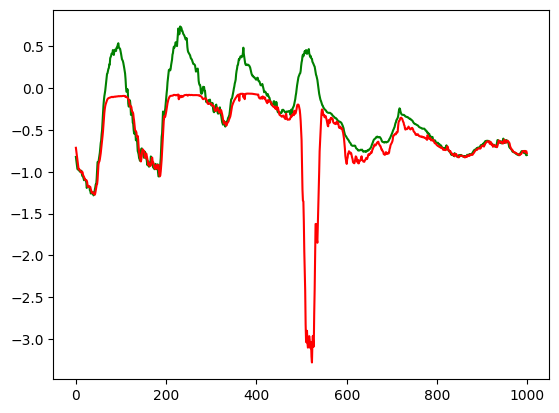

In [ ]:
plot_model('model_lstm_v2_recurrent.h5')

Połączenie dwóch warstw typu LSTM, jak widać powyżej nie było słusznym rozwiązaniem. Zdecydowanie lepsze wyniki uzyskał modle z jedną warstwą ale z zwiększoną liczbą wyjść do 64. Tutaj obserwujemy iż model nie radzi sobie z wartościami statunkowo większymi niż średnie.




---



In [ ]:
import tensorflow as tf

# preparation of a network model - addition of dense layer
model_lstm_v3=tf.keras.models.Sequential(name='LSTM')
model_lstm_v3.add(tf.keras.layers.Input(shape=(steps,14)))
model_lstm_v3.add(tf.keras.layers.LSTM(64,activation='tanh'))
model_lstm_v3.add(tf.keras.layers.Dense(32,activation='relu'))
model_lstm_v3.add(tf.keras.layers.Dense(1,activation='linear'))
model_lstm_v3.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22337 (87.25 KB)
Trainable params: 22337 (87.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm_v3.compile(optimizer='Adam',loss='mae')
model_lstm_v3.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_lstm_v3,'model_lstm_v3_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 21s 59ms/step - loss: 0.0709
Epoch 2/50
313/313 [==============================] - 19s 60ms/step - loss: 0.0374
Epoch 3/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0332
Epoch 4/50
313/313 [==============================] - 19s 61ms/step - loss: 0.0305
Epoch 5/50
313/313 [==============================] - 18s 58ms/step - loss: 0.0298
Epoch 6/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0318
Epoch 7/50
313/313 [==============================] - 19s 61ms/step - loss: 0.0291
Epoch 8/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0285
Epoch 9/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0276
Epoch 10/50
313/313 [==============================] - 19s 61ms/step - loss: 0.0267
Epoch 11/50
313/313 [==============================] - 18s 57ms/step - loss: 0.0257
Epoch 12/50
313/313 [==============================] - 24s 77ms/step - loss: 0.0256
E

<ipython-input-17-62e3b76b3472>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_lstm_v3,'model_lstm_v3_recurrent.h5')


32/32 [==============================] - 2s 29ms/step


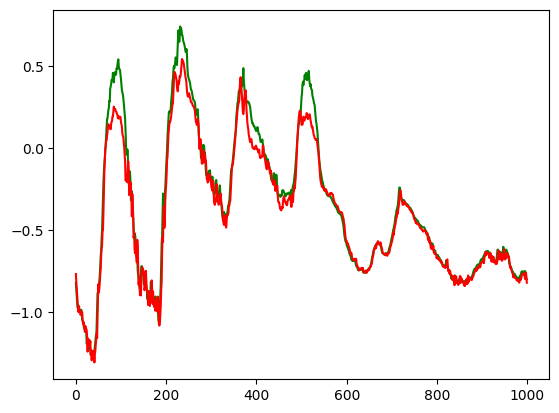

In [ ]:
plot_model('model_lstm_v3_recurrent.h5')

W tym przypadu model z jedną warstwą LSTM z wyjściem rzędu 64 został wzbogacony o warstwę gęstą o funkcji aktywacji *relu*. Wizualnie model dość dobrze przewidział wartości temperatur, jednakże poprzez dodanie kolejnej warstwy błąd wzrósł o 0.1 w stosunku do modelu bez dodatkowej warstwy.



---



In [ ]:
import tensorflow as tf

# preparation of a network model
model_lstm_v4=tf.keras.models.Sequential(name='LSTM')
model_lstm_v4.add(tf.keras.layers.Input(shape=(steps,14)))
model_lstm_v4.add(tf.keras.layers.LSTM(64,activation='tanh',return_sequences=True))
model_lstm_v4.add(tf.keras.layers.LSTM(128,activation='relu',return_sequences=True))
model_lstm_v4.add(tf.keras.layers.LSTM(64,activation='tanh'))
model_lstm_v4.add(tf.keras.layers.Dense(1,activation='linear'))
model_lstm_v4.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 144, 64)           20224     
                                                                 
 lstm_3 (LSTM)               (None, 144, 128)          98816     
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 168513 (658.25 KB)
Trainable params: 168513 (658.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm_v4.compile(optimizer='Adam',loss='mae')
model_lstm_v4.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_lstm_v4,'model_lstm_v4_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 121s 370ms/step - loss: 0.1017
Epoch 2/50
313/313 [==============================] - 110s 350ms/step - loss: 0.0515
Epoch 3/50
313/313 [==============================] - 107s 343ms/step - loss: 0.0399
Epoch 4/50
313/313 [==============================] - 107s 341ms/step - loss: 0.0355
Epoch 5/50
313/313 [==============================] - 107s 342ms/step - loss: 0.0348
Epoch 6/50
313/313 [==============================] - 106s 340ms/step - loss: 0.0335
Epoch 7/50
313/313 [==============================] - 107s 341ms/step - loss: 0.0292
Epoch 8/50
313/313 [==============================] - 106s 340ms/step - loss: 0.0284
Epoch 9/50
313/313 [==============================] - 106s 340ms/step - loss: 0.0289
Epoch 10/50
313/313 [==============================] - 108s 345ms/step - loss: 0.0294
Epoch 11/50
313/313 [==============================] - 106s 338ms/step - loss: 0.0279
Epoch 12/50
313/313 [==============================] - 106s 340

<ipython-input-20-7b9917e825aa>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_lstm_v4,'model_lstm_v4_recurrent.h5')


32/32 [==============================] - 6s 142ms/step


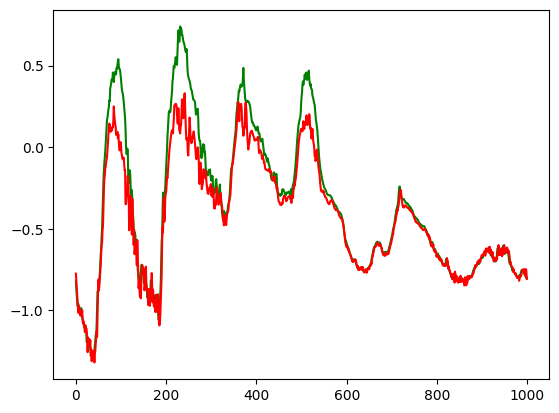

In [ ]:
plot_model('model_lstm_v4_recurrent.h5')

Zwiększnie ilości warstw oraz wymiaru wyjść każdej z warstwy zdecydowanie wydłuża czas obliczeń. Zmiany te także nie przyniosły spodziewanych rezultatów, model zachował się w sposób dość niedokładny. Co więcej użycie funkcji relu także nie przyczyniło się do poprawy dokładności predykcji.

Wnioski:

> Modyfikując model sieci LSTM udało się uzyskać błąd niewiele większy niż błąd sieci z jednostką GRU. Zwiększenie wymiaru wyjścia z LSTM pozwoliło na poprawę działania sieci. Zwiekszanie liczby warstw LSTM wydłużyło czas obliczeń oraz pogorszyło wyniki w porównaniu do jednej warstwy. Również dodanie warstwy gęstej następującej po LSTM pogorszyło dokładność.




---



# Wpływ zmian podziału danych na podzbiony na predykcję

W poniższym eksperymencie starawdzano jak zmieni się dokłądność przewidywania temperatury w czasie krótszym niż 24h, a dokładnie w okresie 12h.
W tym celu jako architekturę wybrano wcześniej zaprezentowaną sieć LSTM z wymiarem wyjściowym jedenj warstwy 64, która została ponownie wytrenowana na danych w innych przedziałach.



In [18]:
steps=72
shift=1 # point of prediction in the future 1 - 10 minutes ahead, 144 - 24 hrs ahead
train_size=10000
train_x=np.zeros((train_size,steps,14))
train_y=np.zeros((train_size,1))
for i in range(0,train_size):
    for j in range(0,steps):
        train_x[i,j,:]=data[i+j]
        train_y[i]=data[i+steps+shift][1]
# preparing the test set
test_size=1000
test_shift=steps*800
test_x=np.zeros((test_size,steps,14))
test_y=np.zeros((test_size,1))
for i in range(0,test_size):
    for j in range(0,steps):
        test_x[i,j,:]=data[i+j+test_shift]
        test_y[i]=data[i+steps+shift+test_shift][1]

In [19]:
model_lstm_64.compile(optimizer='Adam',loss='mae')
model_lstm_64.fit(train_x,train_y,epochs=50)
tf.keras.models.save_model(model_lstm_64,'model_lstm_64_v2_recurrent.h5')

Epoch 1/50
313/313 [==============================] - 13s 34ms/step - loss: 0.0744
Epoch 2/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0344
Epoch 3/50
313/313 [==============================] - 10s 31ms/step - loss: 0.0316
Epoch 4/50
313/313 [==============================] - 9s 29ms/step - loss: 0.0294
Epoch 5/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0289
Epoch 6/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0275
Epoch 7/50
313/313 [==============================] - 9s 28ms/step - loss: 0.0276
Epoch 8/50
313/313 [==============================] - 10s 33ms/step - loss: 0.0261
Epoch 9/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0266
Epoch 10/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0259
Epoch 11/50
313/313 [==============================] - 9s 28ms/step - loss: 0.0255
Epoch 12/50
313/313 [==============================] - 10s 32ms/step - loss: 0.0257
Epoc

<ipython-input-19-cfdfc1b99f87>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_lstm_64,'model_lstm_64_v2_recurrent.h5')


32/32 [==============================] - 1s 10ms/step


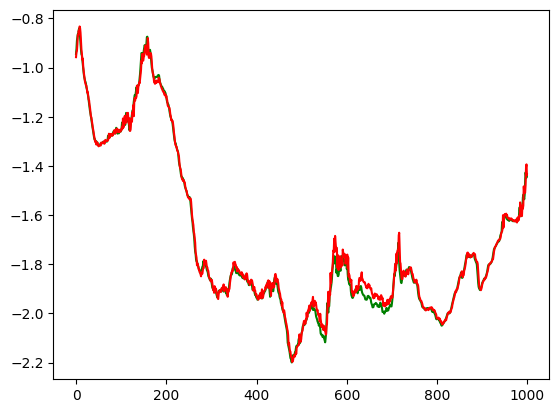

In [20]:
plot_model('model_lstm_64_v2_recurrent.h5')

Skrócenie okresu predykcji o połowę pozwoliło przy tej samej architekturze modelu uzyskać dokładniejsze wyniki. W przypadku okresu 24 godzin sieć tak osiągneła błąd na zbiorze testowym o wartości 0.0409. Tak więc, błąd został prawie trzykrotnie zmniejszony.  


---



# Podsumowanie

Z oceny empirycznej wynika, że wybór typu kompoentu rekurencyjnego sieci nie ma większego znaczenia pod warunkiem dobrania odpwiednich hiperparametrów. W przestawionym problemie póruwnując jedno warstwowe sieci najlepiej wypadła jednostka GRU. Nie mniej jednak odpowiednio użyty LSTM daje zbliżone wartości błędu predykcji.
Jak to zostało powyżej przedstawione dobór hiperparametrów sieci oraz odpowiedni podział danych podanych na wejście modelu ma ogromne znaczenie. Jednakże, czynności te nie są trywialnie i zazwyczaj obarczone są wiloma nieudanymi próbami dostosowania prametrów.